In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [8]:
# Definir a arquitetura do autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# Definir as transformações a serem aplicadas às imagens
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [10]:
# Definir os parâmetros de treinamento
batch_size = 64
learning_rate = 0.001
num_epochs = 10


In [11]:

# Criar o conjunto de dados MNIST
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Criar um DataLoader para o conjunto de dados de treinamento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Criar uma instância do modelo Autoencoder
autoencoder = Autoencoder()

# Definir a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [12]:
# Realizar o treinamento
for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Salvar os pesos do modelo
torch.save(autoencoder.state_dict(), 'autoencoder.pth')


Epoch [1/10], Loss: 0.000986407627351582
Epoch [2/10], Loss: 0.0006982242921367288
Epoch [3/10], Loss: 0.0005356230540201068
Epoch [4/10], Loss: 0.0004873396537732333
Epoch [5/10], Loss: 0.0005189660587348044
Epoch [6/10], Loss: 0.00041596314986236393
Epoch [7/10], Loss: 0.0004264861054252833
Epoch [8/10], Loss: 0.00037688988959416747
Epoch [9/10], Loss: 0.0003579820622690022
Epoch [10/10], Loss: 0.00033744622487574816


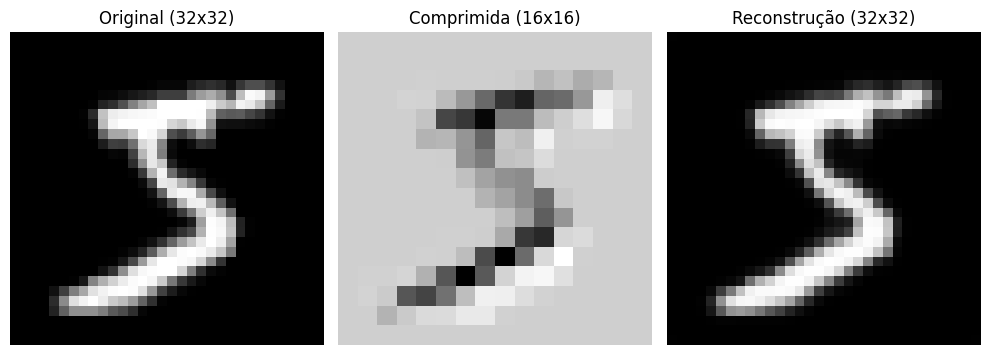

In [13]:
# Obter uma imagem do train_dataset
test_tensor, _ = train_dataset[0]

test_tensor = test_tensor.unsqueeze(0)
compressed_image = autoencoder.encoder(test_tensor)
reconstructed_image = autoencoder.decoder(compressed_image)

test_image = test_tensor.squeeze(0).detach().numpy()
compressed_image = compressed_image.squeeze(0).detach().numpy()
reconstructed_image = reconstructed_image.squeeze(0).detach().numpy()

# Exibindo as imagens
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(test_image[0], cmap='gray')
ax1.axis('off')
ax1.set_title('Original (32x32)')
ax2.imshow(compressed_image[0], cmap='gray')
ax2.axis('off')
ax2.set_title('Comprimida (16x16)')
ax3.imshow(reconstructed_image[0], cmap='gray')
ax3.axis('off')
ax3.set_title('Reconstrução (32x32)')
plt.tight_layout()
plt.show()


In [14]:
# Converter as imagens em tensores
original_tensor = torch.from_numpy(test_image)
reconstructed_tensor = torch.from_numpy(reconstructed_image)

# Calcular a diferença entre as imagens (ruído)
diff = original_tensor - reconstructed_tensor

# Calcular a potência do sinal original (PS)
power_signal = torch.mean(original_tensor**2)

# Calcular a potência do ruído (PR)
power_noise = torch.mean(diff**2)

# Calcular o SNR em dB
snr_db = 10 * torch.log10(power_signal / power_noise)

# Imprimir o valor do SNR em dB
print(f"SNR (dB): {snr_db.item()}")

SNR (dB): 24.570226669311523
